# Machine Learning Immersion Day

This notebook will guide you through the process of prepping time-series data, importing it into Amazon Forecast, as well as using Amazon Forecast to train cutom time-series models, and use the models to predict the estimated eletrical utilization of a residential customer. 

The agenda is below and this content will be available later on GitHub#TODO: Insert Link

To learn more about Amazon Forecast, click [here](https://aws.amazon.com/forecast/).

## Agenda

1. Introduction to Amazon Forecast
1. Obtaining Data
1. Fitting the Data to Forecast
1. Determining the Forecast Horizon (1st pass)
1. Building Your Predictors
1. Visualizing Predictors
1. Making Decisions
1. Next Steps


## Introduction to Amazon Forecast

Amazon Forecast is a fully managed service that uses machine learning to deliver highly accurate forecasts.

Companies today use everything from simple spreadsheets to complex financial planning software to attempt to accurately forecast future business outcomes such as product demand, resource needs, or financial performance. These tools build forecasts by looking at a historical series of data, which is called time series data. For example, such tools may try to predict the future sales of a raincoat by looking only at its previous sales data with the underlying assumption that the future is determined by the past. This approach can struggle to produce accurate forecasts for large sets of data that have irregular trends. Also, it fails to easily combine data series that change over time (such as price, discounts, web traffic, and number of employees) with relevant independent variables like product features and store locations.

Based on the same technology used at Amazon.com, Amazon Forecast uses machine learning to combine time series data with additional variables to build forecasts. Amazon Forecast requires no machine learning experience to get started. You only need to provide historical data, plus any additional data that you believe may impact your forecasts. For example, the demand for a particular color of a shirt may change with the seasons and store location. This complex relationship is hard to determine on its own, but machine learning is ideally suited to recognize it. Once you provide your data, Amazon Forecast will automatically examine it, identify what is meaningful, and produce a forecasting model capable of making predictions that are up to 50% more accurate than looking at time series data alone.

Amazon Forecast is a fully managed service, so there are no servers to provision, and no machine learning models to build, train, or deploy. You pay only for what you use, and there are no minimum fees and no upfront commitments.

If you are not familiar with Amazon Forecast you can learn more about this tool on these pages:

* [Product Page](https://aws.amazon.com/forecast/)
* [GitHub Sample Notebooks](https://github.com/aws-samples/amazon-forecast-samples)
* [Product Docs](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)


## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. [Wikipedia](https://en.wikipedia.org/wiki/Time_series)
1. [Towards Data Science Primer](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
1. [O'Reilly Book](https://www.amazon.com/gp/product/1492041653/)

For this exercise, we are using the individual household electric power consumption dataset. (Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.) The data has been aggregated into hours and has already been downloaded ot this SageMaker Notebook Instance. In future experiments you can download the data yourself, fetch it from sources in S3, query databases, or really anything needed to fetch your time series information.

The cells below will start by importing the standard libraries we will need to to complete this workshop.

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import dateutil.parser

With the libraries loaded, start by using the Pandas library to parse the CSV and render a simple dataframe of the historical information provided.

In [2]:
df = pd.read_csv("../data/item-demand-time.csv", names=['timestamp','value','item'])
df.head(3)

,timestamp,value,item
0,2014-01-01 01:00:00,38.349917,client_12
1,2014-01-01 02:00:00,33.582090,client_12
2,2014-01-01 03:00:00,34.411277,client_12


Notice in the output above there are 3 columns of data:

1. The Timestamp
1. A Value
1. An Item

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present. Next let's take a look to learn more about the dataset provided.


In [3]:
df.describe()

,value
count,23973.000000
mean,50.447323
std,38.721692
min,0.000000
25%,28.688525
50%,40.008292
75%,54.104478
max,212.271973


Not much has been revealed yet, except for the length, and number of unique entities. To make things simpler we are going to now restrict this to a singular time series, or more plainly a single residential customer. Specifically `client_12`

In [4]:
df.drop(df.loc[df['item']!='client_12'].index, inplace=True)

This is fine but we still do not have the data indexed by time, the first preview of the datframe showed that the indexes were just integer values to the left. The cell below will convert the timestamp field to an index so that we can see the date ranges within the dataframe.

In [5]:
df.set_index('timestamp', inplace=True)

The following cell will show the range of dates now:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7991 entries, 2014-01-01 01:00:00 to 2014-11-29 23:00:00
Data columns (total 2 columns):
value    7991 non-null float64
item     7991 non-null object
dtypes: float64(1), object(1)
memory usage: 187.3+ KB


Date ranges at last! Above you can see that the index now ranges from `2014-01-01 01:00:00` to `2014-11-29 23:00:00`. To identify any gaps in our data visually, plot it now.

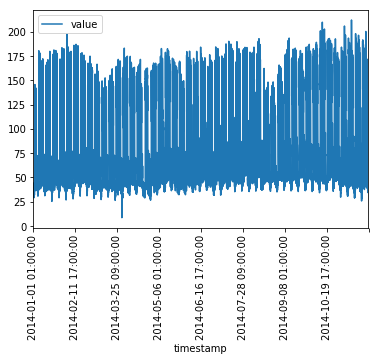

In [7]:
df.plot(rot=90)

That plot looks a little small, the cell below will enlarge the plots for the remainder of the notebook.

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]

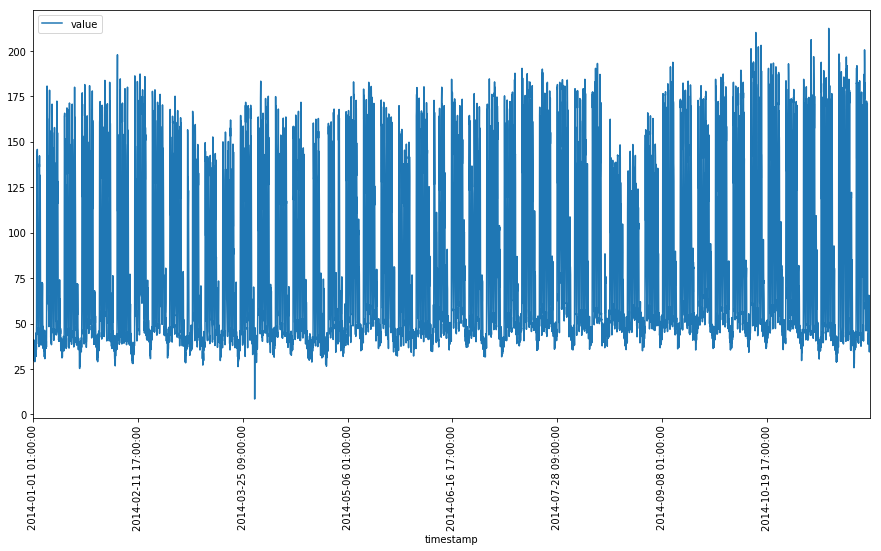

In [9]:
df.plot(rot=90)

This looks like we are not missing any data and can now move onto slicing the information to have a validation set and the train and test set.

Given the data ranges from `2014-01-01 01:00:00` to `2014-11-29 23:00:00`, first split data from January to October, then save the rest into another dataframe.

The data from January to October will be used by Forecast for the training and test set, and then November to December will be used as the validation set later in this notebook.

In [10]:
train_and_test_df = df.loc['2014-01-01':'2014-11-01']
validation_df = df.loc['2014-11-01':]

Next take a look and confirm the date ranges on each dataframe line up to the timelines described above.

In [11]:
train_and_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7295 entries, 2014-01-01 01:00:00 to 2014-10-31 23:00:00
Data columns (total 2 columns):
value    7295 non-null float64
item     7295 non-null object
dtypes: float64(1), object(1)
memory usage: 171.0+ KB


In [12]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 2014-11-01 00:00:00 to 2014-11-29 23:00:00
Data columns (total 2 columns):
value    696 non-null float64
item     696 non-null object
dtypes: float64(1), object(1)
memory usage: 16.3+ KB


Now export them to CSV files and place them into your `data` folder.

In [13]:
train_and_test_df.to_csv("../data/item-demand-time-train.csv", header=False, index=True)
validation_df.to_csv("../data/item-demand-time-validation.csv", header=False, index=True)

## S3, IAM, and Uploads

A few more setup items remain before you can get started with Forecast, primarily you will need an S3 bucket and an IAM role to proceed further, and you will want to upload the train and test file you created to S3 so that Amazon Forecast can use it. The cells below will accomplish all of that for you. 

Note the next cell will sleep for 30 seconds, so it will take just a bit to complete.


In [14]:
iam = boto3.client("iam")

role_name = "ForecastRoleID"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "forecast.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(30) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::059124553121:role/ForecastRoleID


At this point thie next thing to do is import a file into Amazon Forecast, however we do not yet have anything in S3, so we will create a bucket, and upload our target file there.

In [15]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]

print(region)
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "forecastid"
print(bucket_name)
if region != "us-east-1":
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
else:
    s3.create_bucket(Bucket=bucket_name)

us-east-1
059124553121forecastid


Finally, you can uplaod your file:

In [16]:
target_time_series_filename ="elec_data/item-demand-time-train.csv"

boto3.Session().resource('s3').Bucket(bucket_name).Object(target_time_series_filename).upload_file("../data/item-demand-time-train.csv")

## Getting Started With Forecast

Now that all of the required data to get started exists, our next step is to build the dataset groups and datasets required for our problem. Inside Amazon Forecast a DatasetGroup is an abstraction that contains all the datasets for a particular collection of Forecasts. There is no information sharing between Dataset Groups so if you'd like to try out various alternatives to the schemas we create below, you could create a new DatasetGroup and make your changes inside its corresponding Datasets.

The order of the process below will be as follows:

1. Create a DatasetGroup for this immersion day.
1. Create a `Target-Time-Series` Dataset.
1. Attach the Dataset to the DatasetGroup.
1. Import the data into the Dataset.
1. Generate Forecasts with ARIMA, Prophet, and DeepAR+.
1. Export their Forecasts.
1. Plot the Forecasts and metrics. 

At that point we can see which model is best and discuss how to add related data to our Dataset Groups.

The cell below defines a few global settings for our immersion day.

### Definitions:

* DATASET_FREQUENCY: How frequently the data is measured in our target_time_series file aka the train and test dataset.
* TIMESTAMP_FORMAT: The format used for our timestamp.
* project: Just a string that helps label the assets created later.
* datasetName: The name of the Dataset that will be created.
* datasetGroupName: The name of the dataset group that will be created.

In [17]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'forecast_immersion_day'
datasetName= project+'_target_ds'
datasetGroupName= project +'_dsg'

Configure your AWS APIs

In [18]:
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

Create the DatasetGroup, this will be the isolation level for all further work during this immersion day.

In [19]:
# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']

The cell below will describe the DatasetGroup, not much is interesting until we add a dataset later.

In [20]:
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'forecast_immersion_day_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:059124553121:dataset-group/forecast_immersion_day_dsg',
 'DatasetArns': [],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 4, 25, 20, 39, 52, 598000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 4, 25, 20, 39, 52, 598000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '0f5b4b1d-de42-49c4-919d-555ad83919b7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 25 Apr 2020 20:39:53 GMT',
   'x-amzn-requestid': '0f5b4b1d-de42-49c4-919d-555ad83919b7',
   'content-length': '275',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

Datasets inside Amazon Forecast require a schema to be defined, there are several that already exist within the service but in this immersion day you will create one from scratch. Note the structure of the dictionary below, it should mirror the CSV file you created earlier. This schema will be used when importing data to make sure that it is parsed correctly from your CSV into a format which Forecast can use for building your models and inferences later.

In [21]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}

Once the schema has been defined you can now create the dataset:

In [22]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

Again the cell below will give the metrics about the Dataset now that it has been created.

In [23]:
target_datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=target_datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:059124553121:dataset/forecast_immersion_day_target_ds',
 'DatasetName': 'forecast_immersion_day_target_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2020, 4, 25, 20, 39, 56, 747000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2020, 4, 25, 20, 39, 56, 747000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'f57e49b9-1cd2-4c7f-bc2a-09cb6f0ab814',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 25 Apr 2020 20:39:58 GMT',
   'x-amzn-requestid': 'f57e49b9-1cd2-4c7f-bc2a-09cb6f0ab814',
   'content-length': '525',
   'connection': 'kee

Before the Dataset can be used, it needs to be attached to a DatasetGroup, the cell below will do that.

In [24]:
# Attach the Dataset to the Dataset Group:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[target_datasetArn])

{'ResponseMetadata': {'RequestId': '0c4d5868-4d8e-45f9-9b7f-b9530fcc7761',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 25 Apr 2020 20:40:00 GMT',
   'x-amzn-requestid': '0c4d5868-4d8e-45f9-9b7f-b9530fcc7761',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

At long last, it is time to import data into Amazon Forecast, the cell below will start the import process for you using all of the resources that you created earlier.

In [25]:
# Finally we can call import the dataset
target_s3DataPath = "s3://"+bucket_name+"/"+target_time_series_filename
datasetImportJobName = 'DSIMPORT_JOB_TARGET'
ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=target_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":target_s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

To see the status immediately after creating the job run the cell below:

In [26]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:059124553121:dataset-import-job/forecast_immersion_day_target_ds/DSIMPORT_JOB_TARGET


The cell below will run and poll every 30 seconds until the import process has completed. This process will take a few minutes to complete so feel free to stretch your legs if needed. After it completes the next step is to start building models, AKA Predictors with Amazon Forecast.

Once it prints `ACTIVE` you are ready to move onto the next section.

In [27]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(60)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


## Creating Predictors

Given that that our data is hourly and we want to generate a forecast on the hour, we will se the frequency to `H` or hourly. Amazon Forecast does limit your horizon to 500 of whatever your frequency interval is, that would mean 500 hours here or around 20 days into the future. For the purposes of this exercise though we are going to set the horizon to 72 or 3 days.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on ARIMA, Prophet, and DeepAR+ respectfully.

### Definitions

* forecast_frequency: The interval for the forecast, in this case hourly.
* forecast_horizon: How many of the intervals to predict in a forecast.
* number_of_backtest_windows: How many validation windows.
* backtest_window_offset: How long the validation window is.

In [28]:
forecast_frequency = "H"
forecast_horizon = 72
number_of_backtest_windows = 1
backtest_window_offset = 72

Next you will need to define the ARNs for each algorithm so that you can train a predictor with it. The sections are the exact same for each algorithm and at the end there is a while loop that will poll until they are all complete and you can move onto the next session. While they are running feel free to review the content within the API calls to better understand what is happening. Also this process will take at least 1 hour to complete.

In [29]:
arima_algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'
prophet_algorithmArn = 'arn:aws:forecast:::algorithm/Prophet'
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

### ARIMA

In [30]:
# Build ARIMA:
# ARIMA Specifics
arima_predictorName= project+'_arima_algo_1'
arima_create_predictor_response=forecast.create_predictor(PredictorName=arima_predictorName, 
    AlgorithmArn=arima_algorithmArn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML= False,
    PerformHPO=False,
    EvaluationParameters= {"NumberOfBacktestWindows": number_of_backtest_windows, 
        "BackTestWindowOffset": backtest_window_offset}, 
    InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
    FeaturizationConfig= {"ForecastFrequency": forecast_frequency, 
        "Featurizations": 
        [
          {"AttributeName": "target_value", 
           "FeaturizationPipeline": 
            [
              {"FeaturizationMethodName": "filling", 
               "FeaturizationMethodParameters": 
                {"frontfill": "none", 
                 "middlefill": "zero", 
                 "backfill": "zero"}
              }
            ]
          }
        ]
    }
)

### Prophet

In [31]:
# Prophet Specifics
prophet_predictorName= project+'_prophet_algo_1'
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
    AlgorithmArn=prophet_algorithmArn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML= False,
    PerformHPO=False,
    EvaluationParameters= {"NumberOfBacktestWindows": number_of_backtest_windows, 
                         "BackTestWindowOffset": backtest_window_offset}, 
    InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
    FeaturizationConfig= {"ForecastFrequency": forecast_frequency, 
        "Featurizations": 
            [
              {"AttributeName": "target_value", 
               "FeaturizationPipeline": 
                [
                  {"FeaturizationMethodName": "filling", 
                   "FeaturizationMethodParameters": 
                    {"frontfill": "none", 
                     "middlefill": "zero", 
                     "backfill": "zero"}
                  }
                ]
              }
            ]
    }
)

### DeepAR+


In [32]:
# DeepAR+ Specifics
prophet_predictorName= project+'_deeparp_algo_1'
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
    AlgorithmArn=deepAR_Plus_algorithmArn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML= False,
    PerformHPO=False,
    EvaluationParameters= {"NumberOfBacktestWindows": number_of_backtest_windows, 
        "BackTestWindowOffset": backtest_window_offset}, 
    InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
    FeaturizationConfig= {"ForecastFrequency": forecast_frequency, 
        "Featurizations": 
            [
              {"AttributeName": "target_value", 
               "FeaturizationPipeline": 
                [
                  {"FeaturizationMethodName": "filling", 
                   "FeaturizationMethodParameters": 
                    {"frontfill": "none", 
                     "middlefill": "zero", 
                     "backfill": "zero"}
                  }
                ]
              }
            ]
    }
)

These calls will take an hour or so to complete in full. So feel free to take lunch here, go grab a pint, really anything that is going to kill a decent volume of time.

The following while loop will evaluate the status of all your predictor jobs and will conclude once all the predictors are available for use.

In [34]:
in_progress_predictors = [
    arima_create_predictor_response['PredictorArn'],
    prophet_create_predictor_response['PredictorArn'],
    deeparp_create_predictor_response['PredictorArn']
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for predictor_arn in in_progress_predictors:
        predictor_response = forecast.describe_predictor(
            PredictorArn = predictor_arn
        )
        status = predictor_response["Status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(predictor_arn))
            in_progress_predictors.remove(predictor_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(predictor_arn))
            in_progress_predictors.remove(predictor_arn)
    
    if len(in_progress_predictors) <= 0:
        break
    else:
        print("At least one Predictor build is still in progress")
        
    time.sleep(60)

Build succeeded for arn:aws:forecast:us-east-1:059124553121:predictor/forecast_immersion_day_arima_algo_1
Build succeeded for arn:aws:forecast:us-east-1:059124553121:predictor/forecast_immersion_day_deeparp_algo_1
At least one Predictor build is still in progress
Build succeeded for arn:aws:forecast:us-east-1:059124553121:predictor/forecast_immersion_day_prophet_algo_1


## Examine the Predictors

Once each of the Predictors is in an Active state you can get metrics about it to better understand its accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast

### ARIMA

ARIMA is one of the gold standards for time series forecasting. This algorithm is not particularly sophisticated but it is reliable and can help us understand a baseline of performance. To note it does not really understand seasonality very well and it does not support any item metadata or related time series information. Due to that we will explore it here but not after adding other datasets.

In [35]:
# ARIMA Metrics
arima_arn = arima_create_predictor_response['PredictorArn']
arima_metrics = forecast.get_accuracy_metrics(PredictorArn=arima_arn)
pp = pprint.PrettyPrinter()
pp.pprint(arima_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 21.709043475763846,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.056096149076292526,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.15560934174313193,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.10626917818062076,
                                                                                          'Quantile': 0.1}]}},
                                            

Overall our RMSE is 21.709043475763846... This will help you rank your other predictors where you look to see a reduction in RMSE. Overall performance looks like this:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                |
|-----------|--------------------|---------------------|---------------------|--------------------|
| ARIMA     | 21.709043475763846 | 0.10626917818062076 | 0.15560934174313193 | 0.056096149076292526 |

Again these particular values will help us evaluate the other predictors.

### Prophet

Same as ARIMA, now you should look at the metrics from it.

In [36]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response['PredictorArn']
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 19.700664971781258,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.06805254713759812,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.16490751861824904,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.05285156360310547,
                                                                                          'Quantile': 0.1}]}},
                                           

Here you see an RMSE of 19.700664971781258.... Just a bit lower than ARIMA, but at this point Prophet has not had a chance to use any of its abilities to integrate related time series information. Prophet's performance compared to ARIMA is:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                 |
|-----------|--------------------|---------------------|---------------------|---------------------|
| ARIMA     | 21.709043475763846 | 0.10626917818062076 | 0.15560934174313193 | 0.056096149076292526 |
| Prophet   | 19.700664971781258  | 0.05285156360310547 | 0.16490751861824904  | 0.06805254713759812 |

What this tells us is that when querying the 10% quantile we see less of an error from Prophet, also in the 90% but we see a bit worse performance in the 50% quantile. Next will be DeepAR+.



### DeepAR+

Same as Prophet and ARIMA, now you should look at the metrics from it.

In [37]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 8.682702126461086,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.031133268291404875,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.06469480145285833,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.03181481737424046,
                                                                                          'Quantile': 0.1}]}},
                                      

Here you see an RMSE of 8.682702126461086... Much lower than ARIMA or Prophet, in this case we have a definitively better model from a metrics perspective for DeepAR+!


| Predictor | RMSE               | 10%                 | 50%                 | 90%                 |
|-----------|--------------------|---------------------|---------------------|---------------------|
| ARIMA     | 21.709043475763846 | 0.10626917818062076 | 0.15560934174313193 | 0.056096149076292526 |
| Prophet   | 19.700664971781258  | 0.05285156360310547 | 0.16490751861824904  | 0.06805254713759812 |
| DeepAR+   | 8.682702126461086  | 0.03181481737424046 | 0.06469480145285833 | 0.031133268291404875 |


To better understand the quantiles, think of them not as percentages of how accurate a model is but in terms of demand for example:

The 90% or P90 represents a number which states the actual demand will be lower than the predicted value at this time 90% of the time. This is great for a utility provider as they want to know they are going to have the capacity to meet their demand, they may even select a higher quantile like P95 or P99.

Similarly a goods manufacturer may find that it is easy to refill a certain component in their supply chain quite quickly, so the cost of emptying their stock is not problematic. For this use case a lower quantile like P10 may make sense for them. This would indicate that they would exceed their stocks 90% of the time. 

Finally in a retail context you may be in a situation where it is good to just follow the average demand, for that the P50 would be most appropriate.

To explore what this all looks like in a visual format we will now create a Forecast with each Predictor and then export it to s3 where we can download and explore the results.


## Generate a Forecast For Each

The next phase is to generate a Forecast from each Predictor so we can see the results and understand visually which model is performing better.

In [38]:
# ARIMA
arima_forecastName = project+'_arima_algo_forecast'
arima_create_forecast_response=forecast.create_forecast(ForecastName=arima_forecastName,
                                                  PredictorArn=arima_arn)
arima_forecast_arn = arima_create_forecast_response['ForecastArn']

In [39]:
# Prophet
prophet_forecastName = project+'_prophet_algo_forecast'
prophet_create_forecast_response=forecast.create_forecast(ForecastName=prophet_forecastName,
                                                  PredictorArn=prophet_arn)
prophet_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [40]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

Once more, we will periodically poll to see when the forecast creation portion has completed. This step is actually performing the inference with all 3 models that have been trained. It will take a bit of time to spin up custom infrastructure as well as time to execute the inference process. 

In [43]:
in_progress_forecasts = [
    arima_forecast_arn,
    prophet_forecast_arn,
    deeparp_forecast_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for forecast_arn in in_progress_forecasts:
        forecast_response = forecast.describe_forecast(
            ForecastArn = forecast_arn
        )
        status = forecast_response["Status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(forecast_arn))
            in_progress_forecasts.remove(forecast_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(forecast_arn))
            in_progress_forecasts.remove(forecast_arn)
    
    if len(in_progress_forecasts) <= 0:
        break
    else:
        print("At least one Forecast build is still in progress")
        
    time.sleep(60)

At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecast build is still in progress
At least one Forecas

## Exporting your Forecasts to S3

The process that just completed created a cache of results that can be queried using the Forecast API, this cache will be available for 30 days from when the API call completed and can be recreated by simply calling the create forecast API again. In many cases you will want to export the results from the Forecast service to another tool like an ERP system or data warehouse in order for the predictions to be surfaced in other applications.

In this workshop you will simply export them to S3 as a CSV so that we can download the collection and analyize it. The cells below will create 3 export jobs and when they have completed you will find 3 new CSV files(one per model) in the S3 bucket that was created earlier.

In [53]:
#Arima Forecast
arima_path = "s3://" + bucket_name + "/Arima"
arima_job_name = "mlimday_arima_algo_forecast"
arima_export_response = forecast.create_forecast_export_job(ForecastExportJobName=arima_job_name,
    ForecastArn=arima_forecast_arn,
    Destination={
        "S3Config": {
            "Path": arima_path,
            "RoleArn": role_arn
        }
    }
)
armia_export_arn = arima_export_response['ForecastExportJobArn']

In [54]:
# Prophet Forecast
prophet_path = "s3://" + bucket_name + "/Prophet"
prophet_job_name = "mlimday_prophet_algo_forecast"
prophet_export_response = forecast.create_forecast_export_job(ForecastExportJobName=prophet_job_name,
    ForecastArn=prophet_forecast_arn,
    Destination={
        "S3Config": {
            "Path": prophet_path,
            "RoleArn": role_arn
        }
    }
)
prophet_export_arn = prophet_export_response['ForecastExportJobArn']

In [55]:
# DeepAR + Forecast
deep_ar_path = "s3://" + bucket_name + "/DeepAR"
deep_ar_job_name = "mlimday_deep_ar_algo_forecast"
deep_ar_export_response = forecast.create_forecast_export_job(ForecastExportJobName=deep_ar_job_name,
    ForecastArn=deeparp_forecast_arn,
    Destination={
        "S3Config": {
            "Path": deep_ar_path,
            "RoleArn": role_arn
        }
    }
)
deep_ar_export_arn = deep_ar_export_response['ForecastExportJobArn']

This exporting process is another one of those items that will take additional time to complete, but it is the fastest with a normal time of around 5 minutes. The cell below will poll the resources like in the earlier tasks until all export jobs have compelted.

In [57]:
in_progress_exports = [
    armia_export_arn,
    prophet_export_arn,
    deep_ar_export_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for export_arn in in_progress_exports:
        export_response = forecast.describe_forecast_export_job(
            ForecastExportJobArn = export_arn
        )
        status = export_response["Status"]
        if status == "ACTIVE":
            print("Export succeeded for {}".format(export_arn))
            in_progress_exports.remove(export_arn)
        elif status == "CREATE FAILED":
            print("Export failed for {}".format(export_arn))
            in_progress_exports.remove(export_arn)
    
    if len(in_progress_exports) <= 0:
        break
    else:
        print("At least one Forecast Export is still in progress")
        
    time.sleep(60)

Export succeeded for arn:aws:forecast:us-east-1:059124553121:forecast-export-job/forecast_immersion_day_arima_algo_forecast/mlimday_arima_algo_forecast
Export succeeded for arn:aws:forecast:us-east-1:059124553121:forecast-export-job/forecast_immersion_day_deeparp_algo_forecast/mlimday_deep_ar_algo_forecast
At least one Forecast Export is still in progress
At least one Forecast Export is still in progress
At least one Forecast Export is still in progress
Export succeeded for arn:aws:forecast:us-east-1:059124553121:forecast-export-job/forecast_immersion_day_prophet_algo_forecast/mlimday_prophet_algo_forecast


### Obtaining the Forecasts

At this point the forecast exports are all in CSV format and stored in S3 but you will need to obtain the files and store them locally to explore them. The cells below will download them for you.


In [58]:
s3 = boto3.resource('s3')
s3_bucket = s3.Bucket(bucket_name)
# ARIMA File
arima_filename = ""
arima_files = list(s3_bucket.objects.filter(Prefix="Arima"))
for file in arima_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        arima_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, "../data/"+arima_filename)
print(arima_filename)

# Phrophet File
prophet_filename = ""
prophet_files = list(s3_bucket.objects.filter(Prefix="Prophet"))
for file in prophet_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, "../data/"+prophet_filename)
print(prophet_filename)

# DeepAR File
s3 = boto3.resource('s3')
s3_bucket = s3.Bucket(bucket_name)
deep_ar_filename = ""
deep_ar_files = list(s3_bucket.objects.filter(Prefix="DeepAR"))
for file in deep_ar_files:
    #There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deep_ar_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, "../data/"+deep_ar_filename)
print(deep_ar_filename)


mlimday_arima_algo_forecast_2020-04-25T22-30-23Z_part0.csv
mlimday_prophet_algo_forecast_2020-04-25T22-33-37Z_part0.csv
mlimday_deep_ar_algo_forecast_2020-04-25T22-30-36Z_part0.csv


## Evaluating the Forecast

Event before exporting the forecasts themselves we can see a few things in the logs above...

Mainly, the RMSE for each model:

1. ARIMA - RMSE: 21.709043475763846
1. Prophet - RMSE: 19.700664971781258
1. DeepAR+ - RMSE: 8.682702126461086

Those numbers are:

1. ARIMA wQL[0.5]: 0.15560934174313193
1. Prophet wQL[0.5]: 0.16490751861824904
1. DeepAR+ wQL[0.5]: 0.06469480145285833


This tells us that our DeepAR+ model is doing the best when evaluating the p50 result and overall as well.

The next stage would be to plot these numbers over a particular window.

Note the files were downloaded and placed into the `../data/` folder for exploration.

The next group of cells will walk you through understanding the results from the ARIMA model first.

### ARIMA Eval

In [59]:
# ARIMA Eval
arima_predicts = pd.read_csv("../data/" + arima_filename)
arima_predicts.sample()

,item_id,date,p10,p50,p90
6,client_12,2014-11-01T06:00:00Z,4.332824,40.468546,76.604269


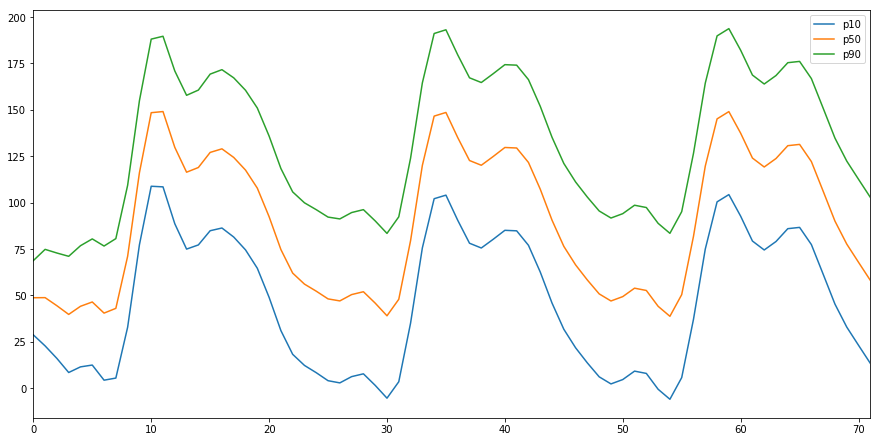

In [60]:
arima_predicts.plot()

The above plot shows the 3 quantiles that were generated and how the predictions shift over time, however the indexes and the actuals are not present yet so the data is not that easy to use.

Start by converting the date column to an actual datetime object.

In [61]:
# Remove the timezone
arima_predicts['date'] = pd.to_datetime(arima_predicts['date'])

Next strip the timezone feature out, this is not needed as all times from Forecast are assumed to be local, also set the date as the index similarly to what was done before when you built the testing and validation datasets.

In [63]:
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)

Now you can plot to see what it looks like over a time window and view the beginning and end of your forecast.

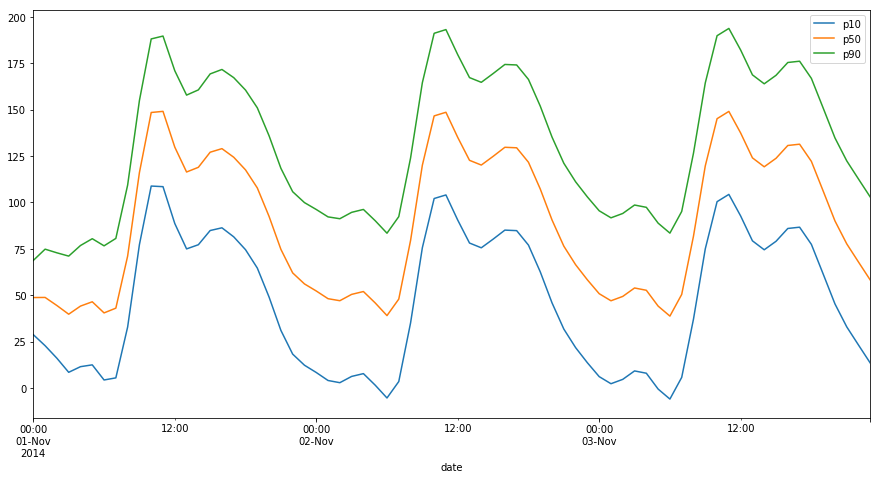

In [64]:
arima_predicts.plot()

In [65]:
print (arima_predicts.index.min())
print (arima_predicts.index.max())

2014-11-01 00:00:00
2014-11-03 23:00:00


Here we can see our prediction goes from November 1st to the 3rd as expectged given our 72 hour interval forecast horizon. Also we can see the cyclical nature of the predictions over the entire timeframe. 

Now we are going to create a dataframe of the prediction values from this Forecast and the actual values.

First let us remove the column ID of item before continuing.

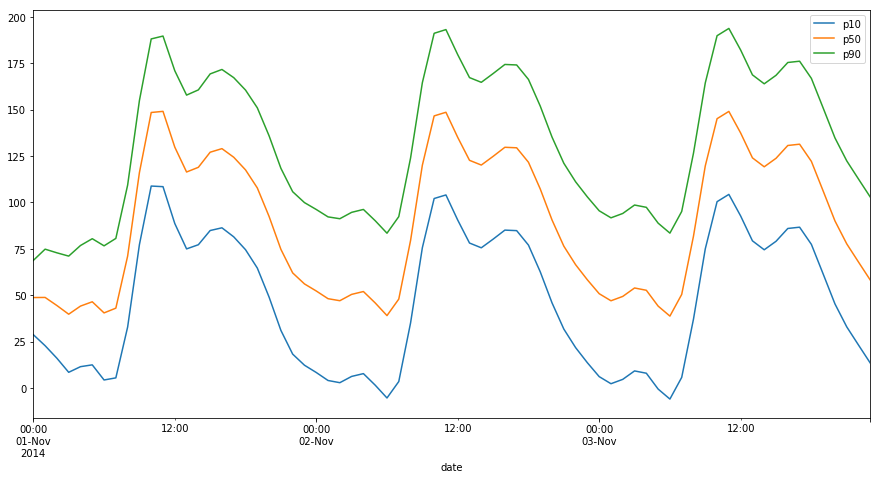

In [66]:
arima_predicts = arima_predicts[['p10', 'p50', 'p90']]
arima_predicts.plot()

Next read in the actual values from our hold out or validation period, the tail funciton will simply show the last few rows of the CSV.

In [68]:
actual_df = pd.read_csv("../data/item-demand-time-validation.csv", names=['timestamp','value','item'])
actual_df.tail()

,timestamp,value,item
691,2014-11-29 19:00:00,47.263682,client_12
692,2014-11-29 20:00:00,51.616915,client_12
693,2014-11-29 21:00:00,49.129353,client_12
694,2014-11-29 22:00:00,41.666667,client_12
695,2014-11-29 23:00:00,42.703151,client_12


Next up slice the validation data to only cover the values that were generated in the forecast.

In [69]:
actual_df = actual_df[(actual_df['timestamp'] >= '2014-10-31') & (actual_df['timestamp'] <= '2014-11-04')]

results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])
for index, row in actual_df.iterrows():
    clean_timestamp = dateutil.parser.parse(row['timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['value'], 'source': 'actual'} , ignore_index=True)
                                   
validation_df = results_df.pivot(columns='source', values='value', index="timestamp")

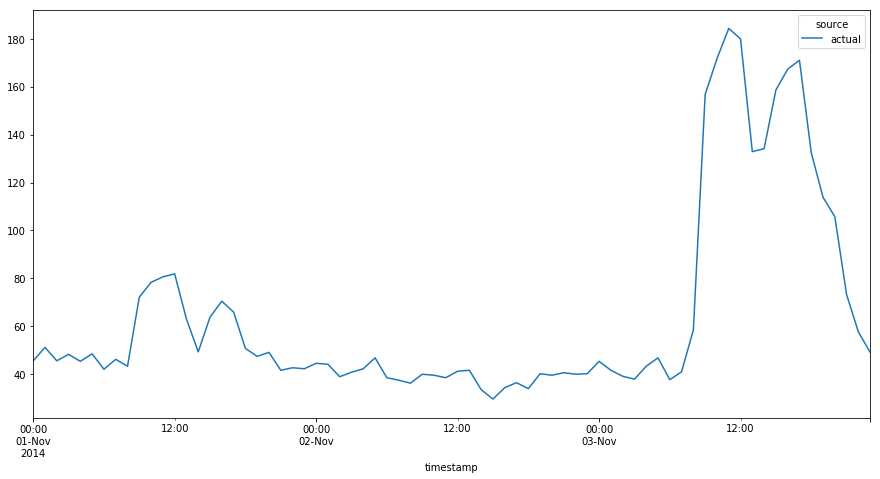

In [70]:
validation_df.plot()

At this point you can join the dataframes together and plot them to see how ARIMA performed against the validtion data.

In [71]:
# Finally let us join the dataframes together
arima_val_df = arima_predicts.join(validation_df, how='outer')

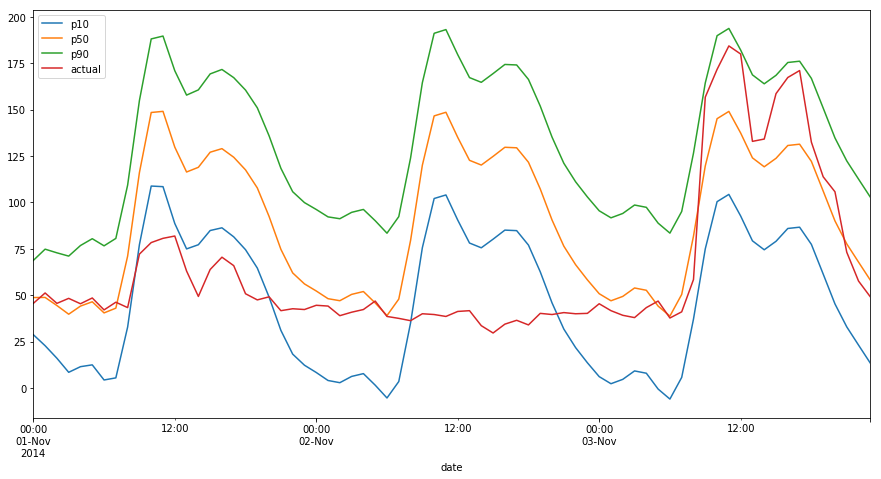

In [72]:
# Plot
arima_val_df.plot()

Your performance may vary but it looks like that the actual demand was lower than the predicted values for all but the last spike and that ARIMA was just expecting the spikes, not understanding a broader behavioral trend.

### Prophet Eval

To speed things up, the above cells for ARIMA have been condensed into simply 2 cells for Prophet, but the logic is the exact same.

In [73]:
# Prophet Eval
prophet_predicts = pd.read_csv("../data/"+prophet_filename)
prophet_predicts.sample()
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date'])
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None)
prophet_predicts.set_index('date', inplace=True)
prophet_predicts = prophet_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
prophet_val_df = prophet_predicts.join(validation_df, how='outer')

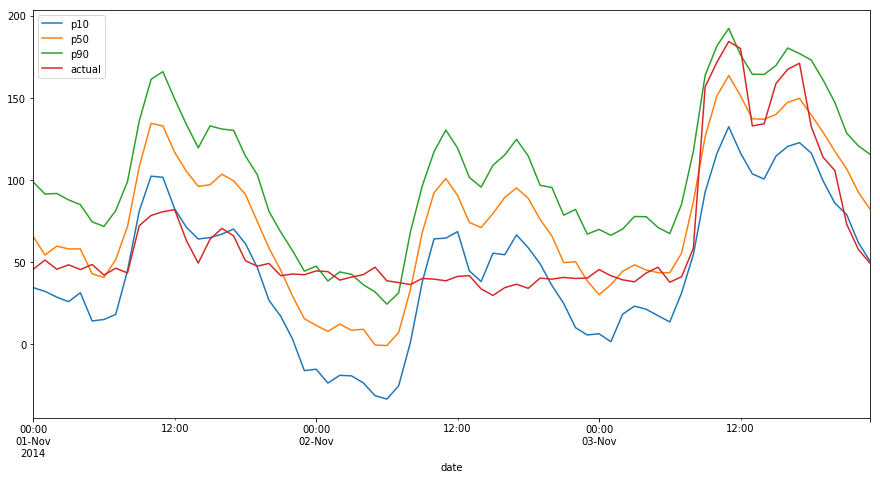

In [74]:
# Plot
prophet_val_df.plot()

Again your actual results may differ but in this specific case it looks like Prophet has a somewhat better understanding of the potential spikes and when they will occur but it also expected far deeper drops than actually occurred. 

### DeepAR+ Eval

Just like Prophet, the DeepAR+ cells have been condensed.

In [75]:
# DeepAR+ Eval
deeparp_predicts = pd.read_csv("../data/"+deep_ar_filename)
deeparp_predicts.sample()
# Remove the timezone
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date'])
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None)
deeparp_predicts.set_index('date', inplace=True)
deeparp_predicts = deeparp_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
deeparp_val_df = deeparp_predicts.join(validation_df, how='outer')

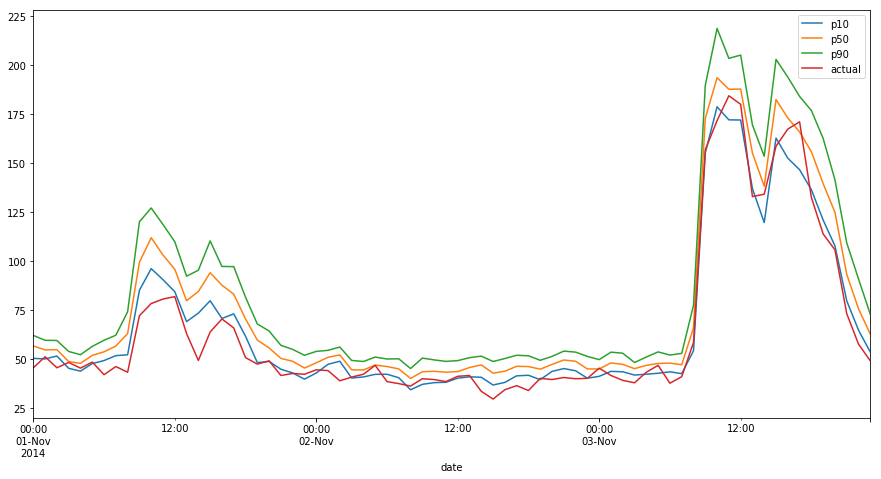

In [76]:
# Plot
deeparp_val_df.plot()

Here we can see DeepAR+ is delivering a far closer prediction to the actuals and really understanding the nuance in the time series. Note how well the spikes are handled in both cases. 

## Plotting it all together

Lastly we will take a look at our p50 prediction from ARIMA, Prophet, and DeepAR+ where the latter leverage related time series data to see how close they are over our validation period. This will be rendered as one plot to visualize which model is best.


In [77]:
# Creating a final df
validation_df_final = validation_df.copy()
validation_df_final = validation_df_final[['actual']]
# ARIMA P50
arima_p50 = arima_predicts.copy()
arima_p50 = arima_p50[['p50']]
arima_p50.rename(columns = {'p50':'ARIMA'}, inplace = True)
# Prophet P50:
prophet_val_p50 = prophet_predicts.copy()
prophet_val_p50 = prophet_val_p50[['p50']]
prophet_val_p50.rename(columns = {'p50':'PROPHET'}, inplace = True)
# DeepAR+ P50:
deeparp_val_p50 = deeparp_predicts.copy()
deeparp_val_p50 = deeparp_val_p50[['p50']]
deeparp_val_p50.rename(columns = {'p50':'DEEPARP'}, inplace = True)
# Join DFs
validation_df_final = validation_df_final.join(arima_p50, how='outer')
validation_df_final = validation_df_final.join(prophet_val_p50, how='outer')
validation_df_final = validation_df_final.join(deeparp_val_p50, how='outer')
validation_df_final.head()


,actual,ARIMA,PROPHET,DEEPARP
timestamp,,,,
2014-11-01 00:00:00,45.605307,48.740407,65.542893,56.734554
2014-11-01 01:00:00,51.202322,48.799871,54.258484,54.699631
2014-11-01 02:00:00,45.605307,44.441035,59.689867,54.827240
2014-11-01 03:00:00,48.300166,39.764575,57.989388,48.776833
2014-11-01 04:00:00,45.398010,44.137237,57.995403,47.855377


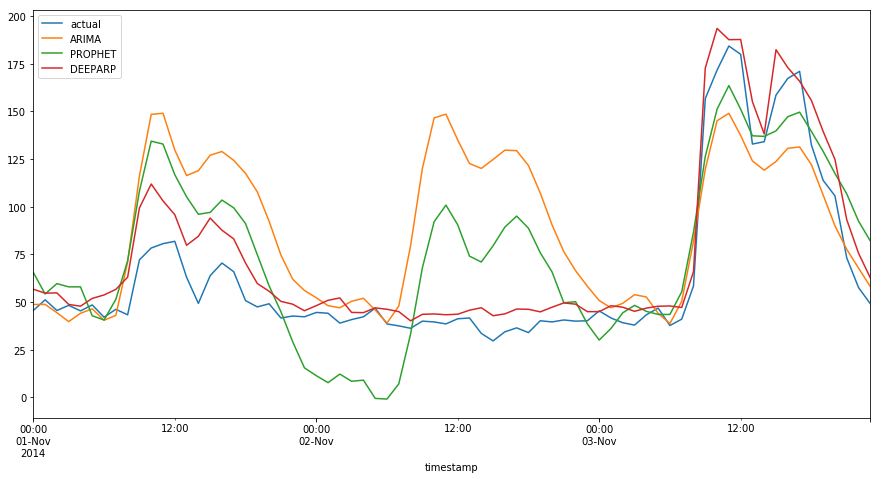

In [78]:
validation_df_final.plot()

Here you can see clearly the way that DeepAR+ was far closer to the actuals than ARIMA or Prophet. This concludes the exercise other than the cleanup process. This notebook and the others in the Forecast-Samples repository can be used to walk through the journey of building a time-series model with Amazon Forecast on your own datasets. 


## Cleanup

The last thing to do now is to tear down the resources that you created in this exercise. The cell below will save a series of variables that are useful in this process. Execute it and then open the `Cleanup.ipynb` notebook to finish this process.

In [80]:
%store datasetGroupArn
%store target_datasetArn
%store role_name
%store bucket_name
%store region
%store ds_import_job_arn
%store prophet_forecast_arn
%store arima_forecast_arn
%store deeparp_forecast_arn
%store arima_arn
%store prophet_arn
%store deeparp_arn
%store armia_export_arn
%store prophet_export_arn
%store deep_ar_export_arn
%store target_datasetArn




Stored 'datasetGroupArn' (str)
Stored 'target_datasetArn' (str)
Stored 'role_name' (str)
Stored 'bucket_name' (str)
Stored 'region' (str)
Stored 'ds_import_job_arn' (str)
Stored 'prophet_forecast_arn' (str)
Stored 'arima_forecast_arn' (str)
Stored 'deeparp_forecast_arn' (str)
Stored 'arima_arn' (str)
Stored 'prophet_arn' (str)
Stored 'deeparp_arn' (str)
Stored 'armia_export_arn' (str)
Stored 'prophet_export_arn' (str)
Stored 'deep_ar_export_arn' (str)
Stored 'target_datasetArn' (str)
